# Max Range Visualization

This notebook visualizes the farthest points detected by your ADS-B receiver from `max_ranges.json`.

It provides:
- A 2D polar envelope (max range vs bearing).
- A 3D ENU point cloud of farthest points.
- An optional 3D convex hull approximation of the detection volume.

Notes:
- Ensure `max_ranges.json` has been generated by `pocketscope-maxrange` or `python -m pocketscope.tools.max_range_tracker`.
- This notebook assumes it lives in `docs/` and the project `src/` is at `../src`.
- The convex hull requires SciPy; if not installed, that section is skipped.

In [1]:
!pip install matplotlib scipy

In [2]:
# Setup: imports and paths
import json, math, os, sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Add project src to path (assumes this notebook is in docs/)
proj_root = Path.cwd().resolve().parents[0]   # when notebook lives in docs/
src_path = proj_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Import geo helpers from project
from pocketscope.core.geo import geodetic_to_ecef, ecef_to_enu

# Configure input file and site parameters
json_path = proj_root / 'max_ranges.json'  # update if your file lives elsewhere
site_lat, site_lon = 42.00748, -71.20899   # set to your site
site_alt_ft = 0.0                          # optional; if known, set in feet

print('Project root:', proj_root)
print('Using JSON:', json_path)
assert json_path.exists(), 'max_ranges.json not found; set json_path to your generated file'

Project root: /Users/chris.patten/workspace/personal/pocket-scope
Using JSON: /Users/chris.patten/workspace/personal/pocket-scope/max_ranges.json


In [3]:
# Load data
with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)
per_icao = list(data.get('per_icao', {}).values())
print(f'Loaded {len(per_icao)} records')
# Preview a few
per_icao[:3]

Loaded 53 records


[{'icao24': '0d112e',
  'distance_nm': 34.56727290785994,
  'bearing_deg': 272.8267031853512,
  'alt_ft': 26800.0,
  'lat': 42.033272,
  'lon': -71.983188,
  'ts_iso': '2025-09-03T14:25:57.001000+00:00'},
 {'icao24': '394a00',
  'distance_nm': 49.26204138542217,
  'bearing_deg': 217.3438524946954,
  'alt_ft': 25175.0,
  'lat': 41.353271,
  'lon': -71.872009,
  'ts_iso': '2025-09-03T14:18:39.001000+00:00'},
 {'icao24': '4005b9',
  'distance_nm': 47.3043221502386,
  'bearing_deg': 215.69680492178853,
  'alt_ft': 26775.0,
  'lat': 41.365997,
  'lon': -71.821533,
  'ts_iso': '2025-09-03T14:27:59.002000+00:00'}]

## 2D Polar Envelope (Max Range vs Bearing)

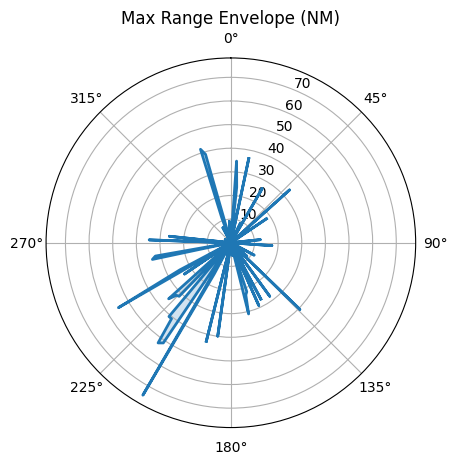

In [4]:
# Bin bearings and take max range per bin
bearing_range = [(float(r['bearing_deg']), float(r['distance_nm'])) for r in per_icao]
bin_deg = 2.0
bins = np.arange(0.0, 360.0, bin_deg)
max_per_bin = []
for b in bins:
    rngs = [rng for brg, rng in bearing_range if b <= brg < b + bin_deg]
    max_per_bin.append(max(rngs) if rngs else 0.0)
# Close the loop for plotting
theta = np.deg2rad(np.append(bins, bins[0]))
r = np.array(max_per_bin + [max_per_bin[0]])

ax = plt.subplot(111, projection='polar')
ax.plot(theta, r, lw=2)
ax.fill(theta, r, alpha=0.2)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('Max Range Envelope (NM)')
plt.show()

## 3D Point Cloud in ENU Coordinates

Point count: 53


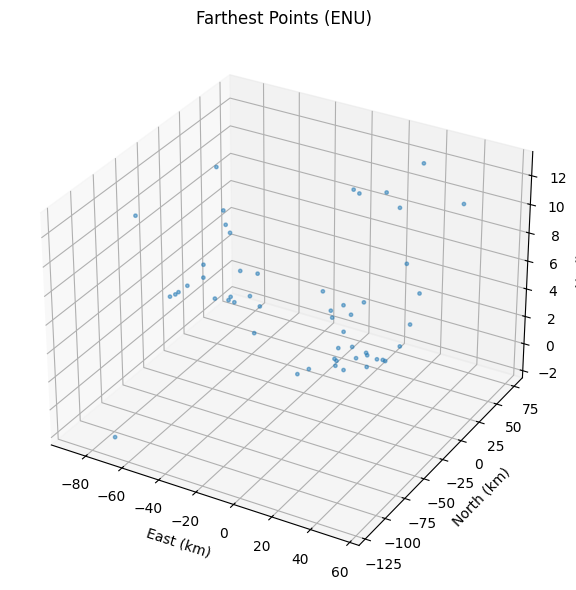

In [5]:
# Convert farthest points to local ENU (km)
pts = []
for rec in per_icao:
    lat, lon = float(rec['lat']), float(rec['lon'])
    alt_ft = rec.get('alt_ft')
    alt_m = float(alt_ft) * 0.3048 if isinstance(alt_ft, (int, float)) else 0.0
    x, y, z = geodetic_to_ecef(lat, lon, alt_m)
    e, n, u = ecef_to_enu(x, y, z, float(site_lat), float(site_lon), float(site_alt_ft) * 0.3048)
    pts.append((e / 1000.0, n / 1000.0, u / 1000.0))  # km

pts = np.array(pts) if pts else np.zeros((0,3))
print('Point count:', len(pts))

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
if len(pts):
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=6, alpha=0.5)
ax.set_xlabel('East (km)')
ax.set_ylabel('North (km)')
ax.set_zlabel('Up (km)')
ax.set_title('Farthest Points (ENU)')
plt.tight_layout()
plt.show()

## Optional: 3D Convex Hull of the Point Cloud

This approximates the outer detection volume. It may overestimate by filling concavities.

Requires SciPy (`pip install scipy`).

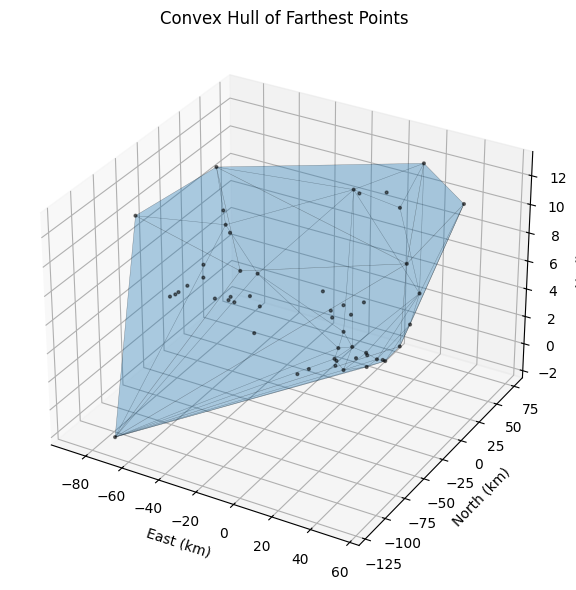

In [6]:
try:
    from scipy.spatial import ConvexHull
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    have_scipy = True
except Exception:
    have_scipy = False

if have_scipy and len(pts) >= 4:
    hull = ConvexHull(pts)
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')
    # Draw hull triangles
    faces = [pts[s] for s in hull.simplices]
    poly = Poly3DCollection(faces, alpha=0.2, facecolor='tab:blue', edgecolor='k', linewidths=0.3)
    ax.add_collection3d(poly)
    # Draw points
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=4, alpha=0.5, color='k')
    ax.set_xlabel('East (km)')
    ax.set_ylabel('North (km)')
    ax.set_zlabel('Up (km)')
    ax.set_title('Convex Hull of Farthest Points')
    plt.tight_layout()
    plt.show()
else:
    print('SciPy not available or insufficient points; skipping hull.')

### Next Steps

- Record more than one point per ICAO (e.g., per-bearing/altitude bins) for a denser envelope.
- Build non-convex surfaces with alpha shapes (Open3D/PyVista) for better fidelity.
- Plot elevation angle by azimuth as a heatmap to see coverage height by direction.

In [7]:
# Convex hull volume (requires scipy)
from math import isfinite

try:
    from scipy.spatial import ConvexHull
except Exception:
    ConvexHull = None

if ConvexHull is None:
    print("SciPy not installed; run `pip install scipy` to enable convex-hull volume.")
else:
    if pts is None or len(pts) < 4:
        print("Need at least 4 points to compute a 3D hull.")
    else:
        # remove any NaNs/infinite and duplicates
        import numpy as np
        good = np.isfinite(pts).all(axis=1)
        uniq = np.unique(pts[good], axis=0)
        if len(uniq) < 4:
            print("Not enough unique, valid points for a 3D hull.")
        else:
            hull = ConvexHull(uniq)
            vol_km3 = hull.volume  # pts are in km => km^3
            vol_m3 = vol_km3 * 1e9
            vol_nm3 = vol_m3 / (1852.0 ** 3)  # cubic nautical miles
            print(f"Convex hull volume: {vol_km3:.6g} km^3  / {vol_m3:.3g} m^3  / {vol_nm3:.6g} nm^3")

Convex hull volume: 124364 km^3  / 1.24e+14 m^3  / 19578.1 nm^3
